
**Selection of hyperparameters for machine learning models**



Мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

Мы будем оценивать качество моделей с помощью метрики AUC-ROC.

# Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

Загрузим набор данных *data.adult.csv*:

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("data.adult.csv")
print(len(data))
print(data.columns)
data.head()

16280
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', '>50K,<=50K'],
      dtype='object')


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


 Найдем все признаки, имеющие пропущенные значения. Удалим из выборки все объекты с пропусками:

In [38]:
linesdrop=[]
for i in range(len(data)):
    for j in range(len(data.columns)):
        if data.iloc[i][j]=='?':
            linesdrop.append(i)
            break
data.drop(index=linesdrop, inplace=True)
print(len(linesdrop))
print(len(data))

933
15347


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделим целевую переменную в отдельную переменную, удалим ее из датасета и преобразуем к бинарному формату.
 - Не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделим их отдельно.

In [245]:
y =(data['>50K,<=50K']=='>50K').astype('int')
x = data.drop(columns='>50K,<=50K')
y1=y
y.value_counts(normalize=True)

0    0.752088
1    0.247912
Name: >50K,<=50K, dtype: float64

In [53]:
x1=x[['age','fnlwgt','capital-gain', 'capital-loss','hours-per-week']]
x1.head()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week
0,34,284843,594,0,60
1,40,190290,0,0,40
2,36,177858,0,0,40
3,22,184756,0,0,30
4,47,149700,15024,0,40


# Обучение классификаторов на вещественных признаках

В данном разделе будем работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Для подбора гиперпараметров воспользуемся перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации будем использовать 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

 Для каждого из первых трех алгоритмов подберем оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов построем график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

## KNN

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate


params1 = {'n_neighbors' : np.arange(2, 20, 1)}
model1 = KNeighborsClassifier()

gs1 = GridSearchCV(model1, params1, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs1.fit(x1, y)
gs1.best_score_, gs1.best_params_


(0.6428335751287712, {'n_neighbors': 5})

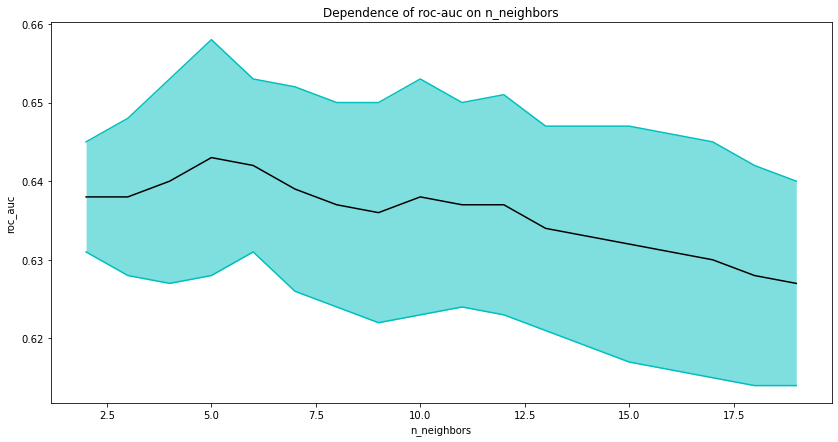

In [145]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
score1=[]
score1min=[]
score1max=[]
for j in np.arange(2, 20, 1):
    model1 = KNeighborsClassifier(n_neighbors=j)
    model1.fit(x1, y)
    score1.append(round(cross_val_score(model1, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    score1min.append(round(cross_val_score(model1, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)-
                round(cross_val_score(model1, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').std(), 3))
    score1max.append(round(cross_val_score(model1, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)+
                round(cross_val_score(model1, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').std(), 3))
plt.figure(figsize=(14, 7))
plt.plot(np.arange(2, 20, 1), score1, color='k')
plt.fill_between(np.arange(2, 20, 1), score1, score1min, alpha=.5, linewidth=0, color='c')
plt.plot(np.arange(2, 20, 1), score1min, color='c')
plt.fill_between(np.arange(2, 20, 1), score1, score1max, alpha=.5, linewidth=0,color='c')
plt.plot(np.arange(2, 20, 1), score1max, color='c')
plt.title("Dependence of roc-auc on n_neighbors")
plt.xlabel("n_neighbors")
plt.ylabel("roc_auc")
plt.show()

## Decision tree

In [224]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
tree = DecisionTreeClassifier(random_state=13)
params2 = {'max_depth' : np.arange(2, 20, 1)}
gs2 = GridSearchCV(tree, params2, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs2.fit(x1, y)
gs2.best_score_, gs2.best_params_


(0.8126342313682405, {'max_depth': 7})

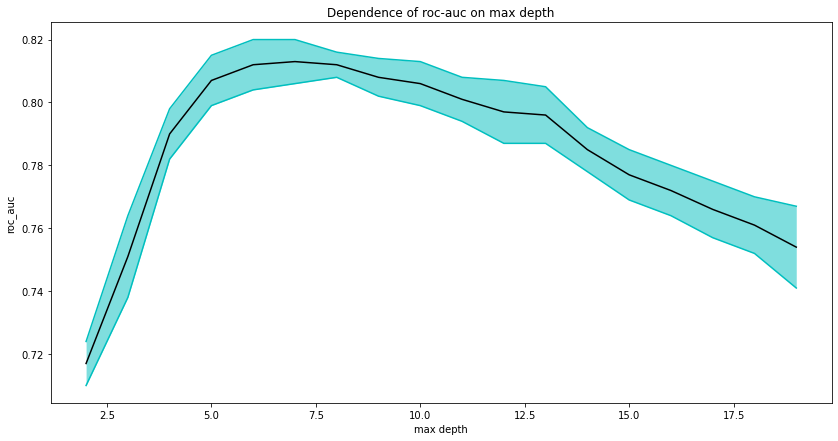

In [147]:

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
score2=[]
score2min=[]
score2max=[]
for m in np.arange(2, 20, 1):
    tree = DecisionTreeRegressor(random_state=13,max_depth=m)
    tree.fit(x1, y)
    score2.append(round(cross_val_score(tree, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    score2min.append(round(cross_val_score(tree, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)-
                round(cross_val_score(tree, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').std(), 3))
    score2max.append(round(cross_val_score(tree, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)+
                round(cross_val_score(tree, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').std(), 3))
plt.figure(figsize=(14, 7))
plt.plot(np.arange(2, 20, 1), score2, color='k')
plt.fill_between(np.arange(2, 20, 1), score2, score2min, alpha=.5, linewidth=0, color='c')
plt.plot(np.arange(2, 20, 1), score2min, color='c')
plt.fill_between(np.arange(2, 20, 1), score2, score2max, alpha=.5, linewidth=0,color='c')
plt.plot(np.arange(2, 20, 1), score2max, color='c')
plt.title("Dependence of roc-auc on max depth")
plt.xlabel("max depth")
plt.ylabel("roc_auc")
plt.show()

## SGD Linear Classifier

In [140]:
import warnings

warnings.filterwarnings('ignore')
from sklearn.linear_model import SGDClassifier
params3 = {'loss' : ['hinge', 'log', 'modified_huber',
                     'squared_hinge','perceptron',
                     'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
model2=SGDClassifier(random_state=13)
gs3=GridSearchCV(model2, params3, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs3.fit(x1, y)
gs3.best_score_, gs3.best_params_


(0.612025649006721, {'loss': 'hinge'})

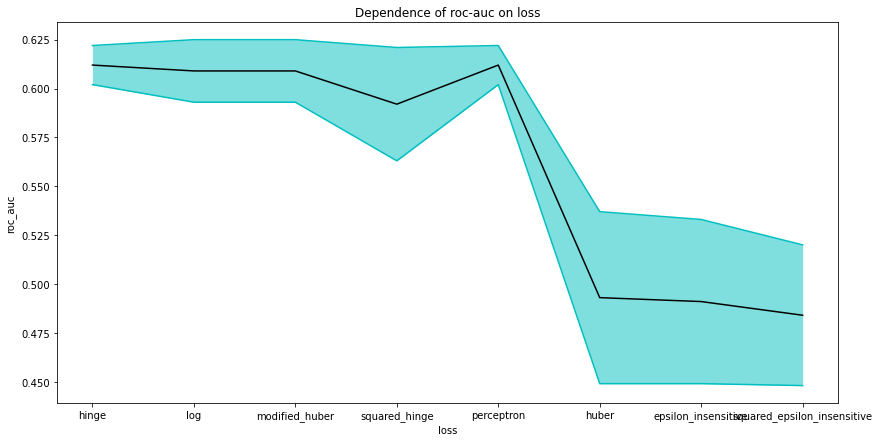

In [141]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
score3=[]
score3min=[]
score3max=[]
s=['hinge', 'log', 'modified_huber',
                     'squared_hinge','perceptron',
                     'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
for w in s:
    model2 = SGDClassifier(random_state=13, loss=w)
    model2.fit(x1, y)
    score3.append(round(cross_val_score(model2, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    score3min.append(round(cross_val_score(model2, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)-
                round(cross_val_score(model2, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').std(), 3))
    score3max.append(round(cross_val_score(model2, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)+
                round(cross_val_score(model2, x1, y, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').std(), 3))
plt.figure(figsize=(14, 7))
plt.plot(s, score3, color='k')
plt.fill_between(s, score3, score3min, alpha=.5, linewidth=0, color='c')
plt.plot(s, score3min, color='c')
plt.fill_between(s, score3, score3max, alpha=.5, linewidth=0,color='c')
plt.plot(s, score3max, color='c')
plt.title("Dependence of roc-auc on loss")
plt.xlabel("loss")
plt.ylabel("roc_auc")
plt.show()

Наибольшее стандартное отклонение Roc_auc на графике зависимости от количества соседей в моделе KNN;
Функция зависимости Roc_auc от максимальной глубины дерева в моделе DecisionTree - выпуклая функция

## Random Forest

Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберем такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучим один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрим подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах будем использовать это количество деревьев:

In [189]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=13)
kf.split(x1)
forest = RandomForestClassifier(n_estimators=100, random_state=13)
forest.fit(x1, y)
final=round(roc_auc_score(forest.predict(x1),y),3)
estimators = forest.estimators_
def predict1(i):
    forest.estimators_ = estimators[0:i] 
    return forest.predict(x1)
for i in range(1,101):
    if round(roc_auc_score(predict1(i), y).mean(), 3)==final:
        print(i)
        break

53


## Gradient Boosting

Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуем график ошибки в зависимости от числа деревьев. Подберем n_estimators, соответствующий минимуму ошибки:

In [221]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, random_state=13)
score4=[]
boost = GradientBoostingClassifier(random_state=13,n_estimators=1)
boost.fit(x1_train, y_train)
l=1
s=round(cross_val_score(boost, x1_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)
score4.append(s)
for h in np.arange(2, 200, 1):
    boost = GradientBoostingClassifier(random_state=13,n_estimators=h)
    boost.fit(x1_train, y_train)
    score4.append(round(cross_val_score(boost, x1_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    if score4[h-1]>s:
        s=score4[h-1]
        l=h
print(s,l)

0.83 157


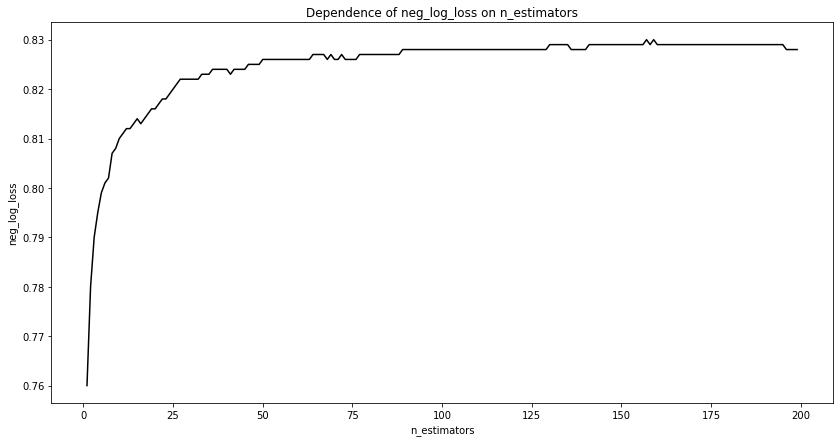

In [204]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 200, 1), score4, color='k')
plt.title("Dependence of neg_log_loss on n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("neg_log_loss")
plt.show()

# Масштабирование признаков

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

Построим гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики, поймем, в чем заключается особенность данных, может ли масшитабирование повлиять на работу этих алгоритмов:

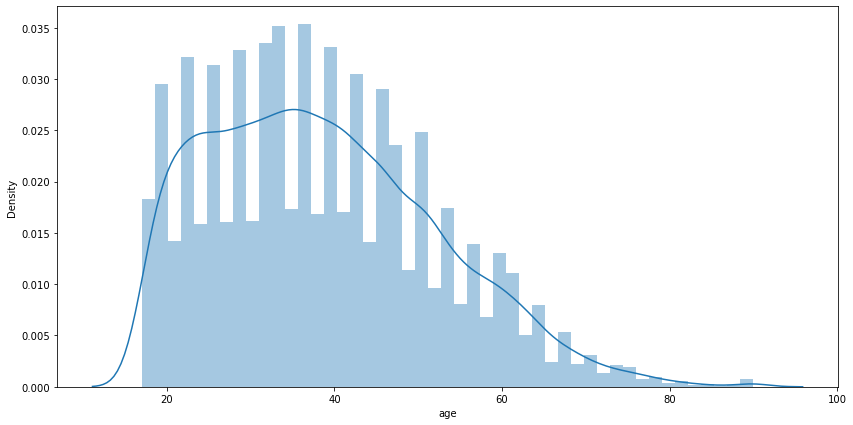

In [209]:
plt.figure(figsize=(14, 7))
sns_plot = sns.distplot(x1['age'])
fig = sns_plot.get_figure()

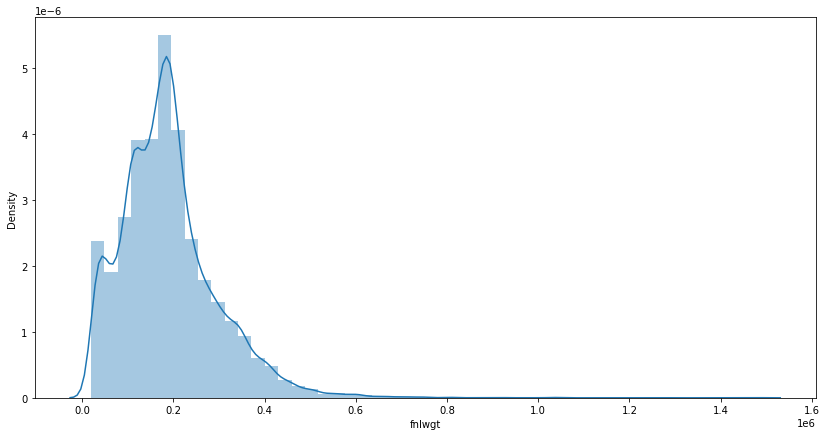

In [214]:
plt.figure(figsize=(14, 7))
sns_plot = sns.distplot(x1['fnlwgt'])
fig = sns_plot.get_figure()

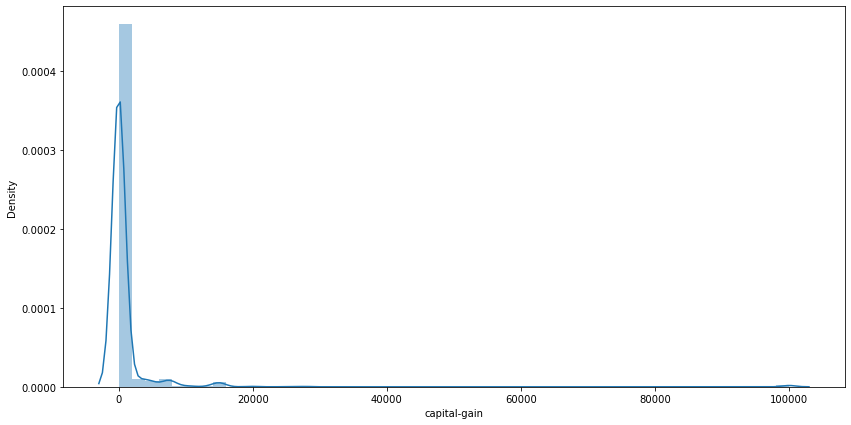

In [213]:
plt.figure(figsize=(14, 7))
sns_plot = sns.distplot(x1['capital-gain'])
fig = sns_plot.get_figure()

Особенность данных в том, что для большинства объектов capital-gain равен нулю, а для остальных он очень большой. 
Объекты выбраны странным образом относительно age. График fnlwgt похож на логнормальное распредление. 
Масштабирование необходимо для capital-gain, алгоритм мог бы улучшиться при масштабировании.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
Масштабируем все вещественные признаки одним из указанных способов и подберем оптимальные значения гиперпараметров аналогично пункту выше:

In [216]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x2 = ss.fit_transform(x1)

## KNN

In [217]:
params1 = {'n_neighbors' : np.arange(2, 20, 1)}
model1 = KNeighborsClassifier()

gs1 = GridSearchCV(model1, params1, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs1.fit(x2, y)
gs1.best_score_, gs1.best_params_


(0.7907255936431679, {'n_neighbors': 19})

## Decision tree

In [225]:
tree = DecisionTreeClassifier(random_state=13)
params2 = {'max_depth' : np.arange(2, 20, 1)}
gs2 = GridSearchCV(tree, params2, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs2.fit(x2, y)
gs2.best_score_, gs2.best_params_


(0.8126342313682405, {'max_depth': 7})

## SGD Linear Classifier

In [219]:
import warnings

warnings.filterwarnings('ignore')
from sklearn.linear_model import SGDClassifier
params3 = {'loss' : ['hinge', 'log', 'modified_huber',
                     'squared_hinge','perceptron',
                     'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
model2=SGDClassifier(random_state=13)
gs3=GridSearchCV(model2, params3, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs3.fit(x2, y)
gs3.best_score_, gs3.best_params_


(0.7750199875692806, {'loss': 'log'})

## Random Forest

In [220]:
kf = KFold(n_splits=5, shuffle=True, random_state=13)
kf.split(x2)
forest = RandomForestClassifier(n_estimators=100, random_state=13)
forest.fit(x2, y)
final=round(roc_auc_score(forest.predict(x2),y),3)
estimators = forest.estimators_
def predict1(i):
    forest.estimators_ = estimators[0:i] 
    return forest.predict(x2)
for i in range(1,101):
    if round(roc_auc_score(predict1(i), y).mean(), 3)==final:
        print(i)
        break

53


## Gradient Boosting

In [222]:
x2_train, x2_test, y_train, y_test = train_test_split(x2, y, random_state=13)
score4=[]
boost = GradientBoostingClassifier(random_state=13,n_estimators=1)
boost.fit(x2_train, y_train)
l=1
s=round(cross_val_score(boost, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)
score4.append(s)
for h in np.arange(2, 200, 1):
    boost = GradientBoostingClassifier(random_state=13,n_estimators=h)
    boost.fit(x2_train, y_train)
    score4.append(round(cross_val_score(boost, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    if score4[h-1]>s:
        s=score4[h-1]
        l=h
print(s,l)

0.83 159


Улучшилось качество у более слабых моделей: у KNN и SGDClassifier

# Подбор комбинаций гиперпараметров

Теперь сделаем перебор нескольких гиперпараметров по сетке и найдем оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

## KNN

In [223]:
params5 = {'n_neighbors' : np.arange(2, 20, 1),
           'metric': ['cityblock', 'cosine','euclidean', 'haversine','l1', 'l2', 'manhattan', 'nan_euclidean']}

model5 = KNeighborsClassifier()

gs5 = GridSearchCV(model5, params5, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs5.fit(x2, y)
gs5.best_score_, gs5.best_params_

(0.7927912840306319, {'metric': 'cityblock', 'n_neighbors': 19})

## Decision tree

In [226]:
tree1 = DecisionTreeClassifier(random_state=13)
params6 = {'max_depth' : np.arange(2, 20, 1),
          'criterion':['gini', 'entropy', 'log_loss']}
gs6 = GridSearchCV(tree1, params6, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs6.fit(x2, y)
gs6.best_score_, gs6.best_params_

(0.8126342313682405, {'criterion': 'gini', 'max_depth': 7})

## SGD Linear Classifier

In [227]:
import warnings

warnings.filterwarnings('ignore')
from sklearn.linear_model import SGDClassifier
params7 = {'loss' : ['hinge', 'log', 'modified_huber',
                     'squared_hinge','perceptron',
                     'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
          'penalty':['l2', 'l1', 'elasticnet']}
model7=SGDClassifier(random_state=13)
gs7=GridSearchCV(model7, params7, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs7.fit(x2, y)
gs7.best_score_, gs7.best_params_


(0.7754173112360976, {'loss': 'log', 'penalty': 'elasticnet'})

## Random Forest

In [228]:
forest1=RandomForestClassifier(n_estimators=53, random_state=13)
params8 = {'max_features' : ['sqrt', 'log2', 'None'],
          'criterion':['gini', 'entropy', 'log_loss']}
gs8 = GridSearchCV(forest1, params8, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs8.fit(x2, y)
gs8.best_score_, gs8.best_params_

(0.7822172681756818, {'criterion': 'entropy', 'max_features': 'sqrt'})

## Gradient Boosting

In [230]:
boost1=GradientBoostingClassifier(n_estimators=159, random_state=13)
params8 = {'max_features' : ['sqrt', 'log2', 'auto'],
          'criterion':['friedman_mse', 'squared_error', 'mse']}
gs9 = GridSearchCV(boost1, params8, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc')
gs9.fit(x2, y)
gs9.best_score_, gs9.best_params_

(0.8371268588828341, {'criterion': 'friedman_mse', 'max_features': 'auto'})

Лучшее качество у бустинга

Дольше обучается лес или бустинг, так как это более сложные алгоритмы. 
Скорее всего, бустинг обучается дольше, так как каждое новое дерево исправляет ошибку старого.

# Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

Преобразуем все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [268]:
cols1=['age','fnlwgt','capital-gain', 'capital-loss','hours-per-week']
cols2=['workclass', 'education','marital-status', 'occupation', 'relationship','race', 'sex']
x3=pd.get_dummies(x[cols2])
x2=pd.DataFrame(x2)
x_final = pd.concat([x2, x3], axis=1)
x_final

,0,1,2,3,4,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,-0.339942,0.894267,-0.062143,-0.215504,1.587927,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.100105,0.007787,-0.148709,-0.215504,-0.032711,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,-0.193260,-0.108769,-0.148709,-0.215504,-0.032711,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
3,-1.220038,-0.044097,-0.148709,-0.215504,-0.843031,0,0,0,0,1,...,1,0,0,0,0,0,0,1,1,0
4,0.613495,-0.372764,2.040794,-0.215504,-0.032711,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,-1.000014,3.049439,-0.148709,-0.215504,-0.032711,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
16276,-0.486625,0.170714,2.040794,-0.215504,0.372448,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
16277,-0.853331,-0.796939,-0.148709,-0.215504,-0.032711,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
16278,1.493590,0.742919,-0.148709,-0.215504,-0.032711,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


Добавим к масштабированным вещественным признакам закодированные категориальные и обучим алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измерим качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

## KNN

In [272]:
from sklearn.pipeline import Pipeline
x_train, x_test, y1_train, y1_test = train_test_split(x_final, y1, random_state=13)
model10=KNeighborsClassifier(n_neighbors=19, metric = 'cityblock')
model10.fit(x_train, y1_train)
print(round(cross_val_score(model1, x_test, y1_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))


0.853


## Decision tree

In [274]:
tree2=DecisionTreeClassifier(random_state=13, criterion = 'gini' , max_depth = 7)
tree2.fit(x_train, y1_train)
print(round(cross_val_score(tree2, x_test, y1_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))


0.858


## SGD Linear Classifier

In [275]:
model11=SGDClassifier(random_state=13, loss='log', penalty='elasticnet')
model11.fit(x_train, y1_train)
print(round(cross_val_score(model11, x_test, y1_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))


0.899


## Random Forest

In [276]:
forest2=RandomForestClassifier(n_estimators=53, random_state=13, criterion='entropy', max_features ='sqrt')
forest2.fit(x_train, y1_train)
print(round(cross_val_score(forest2, x_test, y1_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))


0.894


## Gradient Boosting

In [289]:
boost2=GradientBoostingClassifier(n_estimators=159, random_state=13, criterion='friedman_mse', max_features='auto')
boost2.fit(x_train, y1_train)
print(round(cross_val_score(boost2, x_test, y1_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))


0.912


Лучший результат по-прежнему у бустинга.

# Поиск новых полезных признаков

 Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим следующим образом:
* добавим к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используем только исходные числовые признаки)
* затем снизим размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберем один метод и подберем для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.


## KNN

In [301]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm import tqdm
score5=[]
p1 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=1)), 
    ('model_', KNeighborsClassifier(n_neighbors=19, metric = 'cityblock'))])
p1.fit(x2_train, y_train)
score5.append(round(cross_val_score(p1, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
l=1
s=score5[0]
for i in tqdm(range(2,21)):
    p1 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif,k=i)), 
    ('model_', KNeighborsClassifier(n_neighbors=19, metric = 'cityblock'))])
    p1.fit(x2_train, y_train)
    score5.append(round(cross_val_score(p1, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    if score5[i-1]>s:
        s=score5[i-1]
        l=i
print(score5)
print(s,l)

100%|███████████████████████████████████████████| 19/19 [00:36<00:00,  1.94s/it]

[0.648, 0.737, 0.759, 0.785, 0.797, 0.79, 0.788, 0.789, 0.791, 0.788, 0.787, 0.794, 0.793, 0.794, 0.795, 0.793, 0.795, 0.793, 0.79, 0.788]
0.797 5


In [316]:
poly = PolynomialFeatures(2)
x2_new=poly.fit_transform(x2)
select = SelectKBest(score_func=mutual_info_classif, k=5)
z = select.fit_transform(x2_new,y)
z=pd.DataFrame(z)
x_final1 = pd.concat([z, x3], axis=1)
x3_train, x3_test, y3_train, y3_test = train_test_split(x_final1, y, random_state=13)
model12=KNeighborsClassifier(n_neighbors=19, metric = 'cityblock')
model12.fit(x3_train, y3_train)
print((round(cross_val_score(model12, x3_test, y3_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)))

0.875


## Decision tree

In [321]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
score6=[]
p2 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=1)), 
    ('model_', DecisionTreeClassifier(random_state=13, criterion = 'gini' , max_depth = 7))])
p2.fit(x2_train, y_train)
score6.append(round(cross_val_score(p2, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
l=1
s=score6[0]
for i in tqdm(range(2,21)):
    p2 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=i)), 
    ('model_', DecisionTreeClassifier(random_state=13, criterion = 'gini' , max_depth = 7))])
    p2.fit(x2_train, y_train)
    score6.append(round(cross_val_score(p2, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    if score6[i-1]>s:
        s=score6[i-1]
        l=i
print(score6)
print(s,l)

100%|███████████████████████████████████████████| 19/19 [00:31<00:00,  1.66s/it]

[0.628, 0.737, 0.747, 0.76, 0.782, 0.784, 0.775, 0.787, 0.795, 0.801, 0.797, 0.799, 0.796, 0.797, 0.796, 0.8, 0.797, 0.797, 0.796, 0.79]
0.801 10


In [322]:
select1=RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=10)
z1 = select1.fit_transform(x2_new,y)
z1=pd.DataFrame(z1)
x_final2 = pd.concat([z1, x3], axis=1)
x4_train, x4_test, y4_train, y4_test = train_test_split(x_final2, y, random_state=13)
tree3=DecisionTreeClassifier(random_state=13, criterion = 'gini' , max_depth = 7)
tree3.fit(x4_train, y4_train)
print((round(cross_val_score(tree3, x4_test, y4_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)))

0.85


## SGD Linear Classifier

In [324]:
from sklearn.feature_selection import SelectFromModel
score7=[]
p3 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  max_features=1)), 
    ('model_', SGDClassifier(random_state=13, loss='log', penalty='elasticnet'))])
p3.fit(x2_train, y_train)
score7.append(round(cross_val_score(p3, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
l=1
s=score7[0]
for i in tqdm(range(2,21)):
    p3 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  max_features=i)), 
    ('model_', SGDClassifier(random_state=13, loss='log', penalty='elasticnet'))])
    p3.fit(x2_train, y_train)
    score7.append(round(cross_val_score(p3, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    if score7[i-1]>s:
        s=score7[i-1]
        l=i
print(score7)
print(s,l)

100%|███████████████████████████████████████████| 19/19 [05:50<00:00, 18.47s/it]

[0.604, 0.681, 0.767, 0.772, 0.775, 0.772, 0.774, 0.776, 0.778, 0.781, 0.793, 0.794, 0.788, 0.801, 0.803, 0.789, 0.784, 0.79, 0.775, 0.793]
0.803 15


In [325]:
select2=SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  max_features=15)
z2 = select2.fit_transform(x2_new,y)
z2=pd.DataFrame(z2)
x_final3 = pd.concat([z2, x3], axis=1)
x5_train, x5_test, y5_train, y5_test = train_test_split(x_final3, y, random_state=13)
model13=SGDClassifier(random_state=13, loss='log', penalty='elasticnet')
model13.fit(x5_train, y5_train)
print((round(cross_val_score(model13, x5_test, y5_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)))

0.864


## Random Forest

In [326]:
score8=[]
p4 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif, k=1)), 
    ('model_', RandomForestClassifier(n_estimators=53, random_state=13, criterion='entropy', max_features ='sqrt'))])
p4.fit(x2_train, y_train)
score8.append(round(cross_val_score(p4, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
l=1
s=score8[0]
for i in tqdm(range(2,21)):
    p4 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', SelectKBest(score_func=mutual_info_classif,k=i)), 
    ('model_', RandomForestClassifier(n_estimators=53, random_state=13, criterion='entropy', max_features ='sqrt'))])
    p4.fit(x2_train, y_train)
    score8.append(round(cross_val_score(p4, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    if score8[i-1]>s:
        s=score8[i-1]
        l=i
print(score8)
print(s,l)

100%|███████████████████████████████████████████| 19/19 [01:00<00:00,  3.17s/it]

[0.679, 0.773, 0.786, 0.79, 0.793, 0.792, 0.787, 0.787, 0.783, 0.783, 0.779, 0.771, 0.769, 0.771, 0.775, 0.777, 0.779, 0.778, 0.776, 0.781]
0.793 5


In [327]:
select3=SelectKBest(score_func=mutual_info_classif, k=5)
z3 = select3.fit_transform(x2_new,y)
z3=pd.DataFrame(z3)
x_final4 = pd.concat([z3, x3], axis=1)
x6_train, x6_test, y6_train, y6_test = train_test_split(x_final4, y, random_state=13)
forest3=RandomForestClassifier(n_estimators=53, random_state=13, criterion='entropy', max_features ='sqrt')
forest3.fit(x6_train, y6_train)
print((round(cross_val_score(forest3, x6_test, y6_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)))

0.879


## Gradient Boosting

In [328]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
score9=[]
p5 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=1)), 
    ('model_', GradientBoostingClassifier(n_estimators=159, random_state=13, criterion='friedman_mse', max_features='auto'))])
p5.fit(x2_train, y_train)
score9.append(round(cross_val_score(p5, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
l=1
s=score9[0]
for i in tqdm(range(2,21)):
    p5 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('selector_', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=i)), 
    ('model_', GradientBoostingClassifier(n_estimators=159, random_state=13, criterion='friedman_mse', max_features='auto'))])
    p5.fit(x2_train, y_train)
    score9.append(round(cross_val_score(p5, x2_test, y_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3))
    if score9[i-1]>s:
        s=score9[i-1]
        l=i
print(score9)
print(s,l)

100%|███████████████████████████████████████████| 19/19 [02:04<00:00,  6.55s/it]

[0.628, 0.749, 0.771, 0.783, 0.801, 0.807, 0.809, 0.825, 0.827, 0.828, 0.826, 0.826, 0.824, 0.824, 0.826, 0.827, 0.826, 0.827, 0.826, 0.828]
0.828 10


In [329]:
select4=RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=10)
z4 = select4.fit_transform(x2_new,y)
z4=pd.DataFrame(z4)
x_final5 = pd.concat([z4, x3], axis=1)
x7_train, x7_test, y7_train, y7_test = train_test_split(x_final5, y, random_state=13)
boost3=GradientBoostingClassifier(n_estimators=159, random_state=13, criterion='friedman_mse', max_features='auto')
boost3.fit(x7_train, y7_train)
print((round(cross_val_score(boost3, x7_test, y7_test, cv=KFold(n_splits=5, random_state=13, shuffle=True), scoring='roc_auc').mean(), 3)))

0.908


Улучшилась только модель KNeighborsClassifier

# Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберем из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее построем новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

Подберем по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и построим график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"):

In [388]:
from sklearn.model_selection import cross_val_predict
boost2=GradientBoostingClassifier(n_estimators=159, random_state=13, criterion='friedman_mse', max_features='auto')
boost2.fit(x_train, y1_train)
y_predboost=cross_val_predict(boost2, x_test, y1_test, cv=KFold(n_splits=5, random_state=13, shuffle=True))
y_predboost=pd.DataFrame(y_predboost)
model11=SGDClassifier(random_state=13, loss='log', penalty='elasticnet')
model11.fit(x_train, y1_train)
y_predSGD=cross_val_predict(model11, x_test, y1_test, cv=KFold(n_splits=5, random_state=13, shuffle=True))
y_predSGD=pd.DataFrame(y_predSGD)
date=y_predSGD
result=pd.DataFrame(date)
alpha=0
maxx=0
o=[]
o.append(round(roc_auc_score(result,y1_test),3))
if maxx<round(roc_auc_score(result,y1_test),3):
        maxx=round(roc_auc_score(result,y1_test),3)
        alpha=g
for i in range(1,21):
    g=0.05*i
    date=y_predboost*g+y_predSGD*(1-g)
    result=pd.DataFrame(date)
    result=(result>0.5)
    o.append(round(roc_auc_score(result,y1_test),3))
    if maxx<round(roc_auc_score(result,y1_test),3):
        maxx=round(roc_auc_score(result,y1_test),3)
        alpha=g
print(alpha,maxx)
print(o)

0.5 0.845
[0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.845, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831]


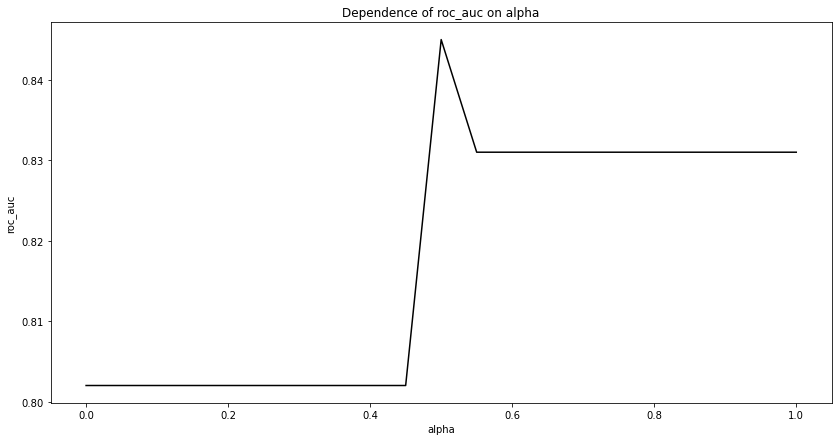

In [390]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(0, 1.05, 0.05), o, color='k')
plt.title("Dependence of roc_auc on alpha")
plt.xlabel("alpha")
plt.ylabel("roc_auc")
plt.show()

Этот подход не дал прирост к качеству по сравнению с взятыми моделями.